<a href="https://colab.research.google.com/github/wildemberg-sales/ML-Breast-Cancer-Diagnosis/blob/main/ML-Breast-Cancer-Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Classificador para identificação de Câncer de Mama baseado em imagens disponibilizadas pela biblioteca da SkLean Diagnostic Wisconsin Breast Cancer Database. Versão 1 do Modelo

In [3]:
# Instalando dependências complementares para o projeto
!pip install -q -U tensorflow-addons
!pip install -q -U keras-utils

In [4]:
import pandas as pd
from numpy import mean
import tensorflow as tf
import keras
from keras.metrics import *
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Add, Conv1D, Dropout, Flatten

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
# Definição das métricas que serão utilizadas no projeto
METRICS = [BinaryAccuracy(name = 'accuracy'),
           TruePositives(thresholds = 0.5, name = 'tp'),
           TrueNegatives(thresholds = 0.5, name = 'tn'),
           FalsePositives(thresholds = 0.5, name = 'fp'),
           FalseNegatives(thresholds = 0.5, name = 'fn'),
           PrecisionAtRecall(recall = 0.5, name = 'precision'),
           SensitivityAtSpecificity(0.5, name = 'sensitivity'),
           SpecificityAtSensitivity(sensitivity = 0.5, name = 'specificity'),
           Recall(name='recall')]

In [9]:
# Carregamento e descrição dos dados que serão utilizados
data = datasets.load_breast_cancer()
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [ ]:
# Criando um data frame em modelo de tabelas
X = pd.DataFrame(data = data.data,
                 columns = data.feature_names)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
# Resultados em formato binário
y = data.target
print(y)
print(data.target_names)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

In [ ]:
# Definindo divisão de dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y,
                                                        test_size = 0.2, # Define que 20% vai ser para a base de teste
                                                        random_state = 0, # Ao passar um número, garante que a divisão aleatória de dados sempre será a mesma
                                                        stratify = y) # Faz o balanceamento da divisão dos dados garantindo proporção das classes nos conjuntos de treino e teste

print(X_treino.shape)
print(X_teste.shape)

(455, 30)
(114, 30)


In [ ]:
clf = KNeighborsClassifier() # defini um modelo para classificação das imagens chamado K e seus vizinhos (na tradução), fazendo a classificação e agrupamento
clf.fit(X_treino, y_treino)
prediction = clf.predict(X_teste)

print(clf.score(X_treino, y_treino))
print(clf.score(X_teste, y_teste))

print(classification_report(y_teste, prediction))

0.9472527472527472
0.9122807017543859
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.93      0.93      0.93        72

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



In [ ]:
# Fazendo escalonamento dos dados para normalização dos dados
escalonador = StandardScaler()
X_treino = escalonador.fit_transform(X_treino)
X_teste = escalonador.transform(X_teste)


In [ ]:
# Ajustando os dados para um modelo tridimensional
X_treino = X_treino.reshape(455, 30, 1)
X_teste = X_teste.reshape(114, 30, 1)

In [ ]:
# Definição de um modelo sequêncial
modelo = Sequential()

# Camada Convolucional unidimensional para extração de características nos dados
modelo.add(Conv1D(filters = 16, # Número de neurônios
                  kernel_size = 2, # Especifica o tamanho da janela de convolução, o que significa que a convolução será aplicada a cada grupo de 2 valores consecutivos da entrada
                  activation = 'relu', # Introduzindo Linearidade na saída da camada
                  input_shape = (30, 1))) # 30 colunas e 1 categoria de classificação

modelo.add(Dropout(0.2)) # ele elimina 20% dos dados de forma aleatória que vem da camada anterior, fazendo com que a camada seguinte complete seu espaço com uma média dos valores que ela recebeu
                          # isso faz com que o modelo não se foque em pequenos detalhes fazendo com que ela tenha noções maiores evitando overfitting

modelo.add(Conv1D(filters = 32,
                  kernel_size = 2,
                  activation = 'relu'))

modelo.add(Flatten()) # Transforma os dados de entrada em um vetor unidimensional, preparando-os para serem alimentados em camadas densas

modelo.add(Dense(32,
                 activation = 'relu'))

modelo.add(Dense(1, # Última camada, ativada com sigmoid que é utilizado para classificação binária (0 ou 1), ela força a saída de um desses dois valores
                 activation = 'sigmoid'))

modelo.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 29, 16)            48        
                                                                 
 dropout_3 (Dropout)         (None, 29, 16)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 28, 32)            1056      
                                                                 
 flatten_3 (Flatten)         (None, 896)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                28704     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29841 (116.57 KB)
Trainable params: 2984

In [ ]:
# Fazendo uma limpeza de cache antes de começar o treinamento
tf.keras.backend.clear_session()


In [ ]:
modelo.compile(optimizer = Adam(learning_rate = 0.001), # o learning_rate é utilizado para definir os tamanhos dos passos que o otimizador dá para atualizar a rede neural
               loss = 'binary_crossentropy', # Entropia binaria cruzada, a medida que o modelo aprende, ele tem que tender a 0 ou 1 como sua saída
               metrics = METRICS) # Utilização das métricas definidas anteriormente para acompanhamento do desempenho do modelo


In [ ]:
# Criando um monitoramento da acurácia
learning_rate = ReduceLROnPlateau(monitor = 'accuracy',
                                  factor = 0.2, # a taxa de aprendizado será multiplicada por 0.2 sempre que as condições forem satisfeitas
                                  patience = 1, # limite de épocas que a taxa de acurácio pode não melhorar, caso ultrapasse, a taxa de aprendizado é reduzida
                                  min_lr = 0.000001, # Limite da taxa de aprendizado, ela não irá diminuir mais que isso
                                  verbose = 1) # usado para imprimir a mensagem que a taxa foi modificada

In [ ]:
# Treinamento da rede neural
%%time

hist = modelo.fit(X_treino,
                  y_treino,
                  steps_per_epoch = 10, # a cada época 10 amostras são processadas
                  epochs = 100,
                  validation_data = (X_teste, y_teste),
                  validation_steps = 10, # a cada época, são 10 validações
                  callbacks = [learning_rate],
                  verbose = 1)

Epoch 1/100
10/10 [==============================] - 4s 127ms/step - loss: 0.5100 - accuracy: 0.8615 - tp: 252.0000 - tn: 140.0000 - fp: 30.0000 - fn: 33.0000 - precision: 0.9714 - sensitivity: 0.9965 - specificity: 0.9706 - recall: 0.8842 - val_loss: 0.3579 - val_accuracy: 0.9298 - val_tp: 68.0000 - val_tn: 38.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_precision: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_recall: 0.9444 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.2373 - accuracy: 0.9473 - tp: 280.0000 - tn: 151.0000 - fp: 19.0000 - fn: 5.0000 - precision: 0.9872 - sensitivity: 1.0000 - specificity: 0.9882 - recall: 0.9825 - val_loss: 0.1756 - val_accuracy: 0.9474 - val_tp: 70.0000 - val_tn: 38.0000 - val_fp: 4.0000 - val_fn: 2.0000 - val_precision: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_recall: 0.9722 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 0.12

In [ ]:
# Métricas processadas durante o treinamento

acc = hist.history['accuracy'] # Acurácia
loss =  hist.history['loss'] # Taxa de perda
fp = hist.history['fp'] # Falsos positivos
fpv = hist.history['val_fp'] # Falsos positivos (validação)
fn = hist.history['fn'] # Falsos negativos
fnv = hist.history['val_fn'] # Falsos negativos (validação)
tp = hist.history['tp'] # Verdadeiros positivos
tpv = hist.history['val_tp'] # Verdadeiros positivos (validação)
tn = hist.history['tn'] # Verdadeiros negativos
tnv = hist.history['val_tn'] # Verdadeiros negativos (validação)
FP = hist.history['fp'][-1] # Nº de falsos positivos na última época de processamento
FN = hist.history['fn'][-1] # Nº de falsos negativos na última época de processamento
TP = hist.history['tp'][-1] # Nº de verdadeiros positivos na última época de processamento
TN = hist.history['tn'][-1] # Nº de verdadeiros negativos na última época de processamento
LOSS = hist.history['loss'][-1] # Taxa de perda na última época de processamento
LOSSV = hist.history['val_loss'][-1] # Taxa de perda (validação) na última época de processamento
ACC = hist.history['accuracy'][-1] # Acurácia na última época de processamento
ACCV = hist.history['val_accuracy'][-1] # Acurácia (validação) na última época de processamento
PRE = hist.history['precision'][-1] # Precisão na última época de processamento
PREV = hist.history['val_precision'][-1] # Precisão (validação) na última época de processamento
REC = hist.history['recall'][-1] # Revocação na última época de processamento
RECV = hist.history['val_recall'][-1] # Revocação (validação) na última época de processamento
LR = hist.history['lr'][-1] # Taxa de aprendizado na última época de processamento


In [ ]:
# Métricas processadas após o final do treinamento

TPR = TP /(TP + FN) # Sensibilidade (taxa de acertos / taxa de verdadeiros positivos)
TNR = TN /(TN + FP) # Especificidade (taxa de verdadeiros negativos)
PPV = TP /(TP + FP) # Precisão (taxa de predições positivas)
NPV = TN /(TN + FN) # Taxa de predições negativas
FPR = FP /(FP + TN) # Taxa de falsos positivos
FNR = FN /(TP + FN) # Taxa de falsos negativos
FDR = FP /(TP + FP) # Taxa de falsas descobertas

OACC = (TP + TN) /(TP + FP + FN + TN) # Acurácia geral
ACCCM = (TP + TN) / (TP + TN + FP + FN) # Acurácia da matriz de confusão
FM = (2 * PRE * REC) / (PRE + REC) # Medida F
F1S = 2*((PRE * REC) / (PRE + REC)) # Pontuação F1
F1S2 = 2 * TP / (2 * TP + FP + FN) # Pontuação F1 (método alternativo)

In [ ]:
print(f'Verdadeiros Positivos: {tp}')
print(f'Falsos Positivos: {fp}')
print(f'Verdadeiros Negativos: {tn}')
print(f'Falsos Negativos: {fn}')

print('--------------------')

print("Matriz de Confusão")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print('--------------------')

print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')


Verdadeiros Positivos: [252.0, 280.0, 281.0, 283.0, 281.0, 282.0, 281.0, 282.0, 282.0, 283.0, 282.0, 281.0, 282.0, 281.0, 282.0, 281.0, 282.0, 280.0, 281.0, 281.0, 283.0, 282.0, 282.0, 283.0, 282.0, 282.0, 283.0, 282.0, 282.0, 283.0, 281.0, 281.0, 282.0, 284.0, 281.0, 283.0, 282.0, 283.0, 282.0, 282.0, 283.0, 281.0, 282.0, 283.0, 281.0, 281.0, 283.0, 283.0, 283.0, 283.0, 281.0, 283.0, 283.0, 281.0, 282.0, 281.0, 283.0, 282.0, 282.0, 282.0, 283.0, 283.0, 281.0, 283.0, 282.0, 283.0, 283.0, 281.0, 282.0, 283.0, 283.0, 281.0, 282.0, 282.0, 282.0, 282.0, 282.0, 281.0, 281.0, 282.0, 281.0, 282.0, 282.0, 281.0, 282.0, 283.0, 281.0, 284.0, 282.0, 282.0, 283.0, 282.0, 283.0, 281.0, 281.0, 283.0, 282.0, 283.0, 283.0, 283.0]
Falsos Positivos: [30.0, 19.0, 18.0, 9.0, 5.0, 4.0, 5.0, 3.0, 4.0, 3.0, 2.0, 4.0, 4.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0, 3.0, 5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 6.0, 4.0, 3.0, 3.0, 3.0, 5.0, 3.0, 3.0, 2.0, 5.0, 3.0, 4.0, 5.0, 4.0, 3.0,

In [ ]:
# Média com base nas últimas 10 épocas de processameto

accU10 = mean(acc[-10])
tpU10 = mean(tp[-10])
fpU10 = mean(fp[-10])
tnU10 = mean(tn[-10])
fnU10 = mean(fn[-10])

print(f'Verdadeiros Positivos: {tpU10}')
print(f'Falsos Positivos: {fpU10}')
print(f'Verdadeiros Negativos: {tnU10}')
print(f'Falsos Negativos: {fnU10}')

print('--------------------')

print("Matriz de Confusão")
print('*Média últimas 10 épocas de processamento')
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print('--------------------')

print(f'Acurácia da Matriz de Confusão: {round(accU10, 2)*100-2}%')


Verdadeiros Positivos: 283.0
Falsos Positivos: 2.0
Verdadeiros Negativos: 168.0
Falsos Negativos: 2.0
--------------------
Matriz de Confusão
*Média últimas 10 épocas de processamento
[283.0] [3.0]
[2.0] [167.0]
--------------------
Acurácia da Matriz de Confusão: 97.0%


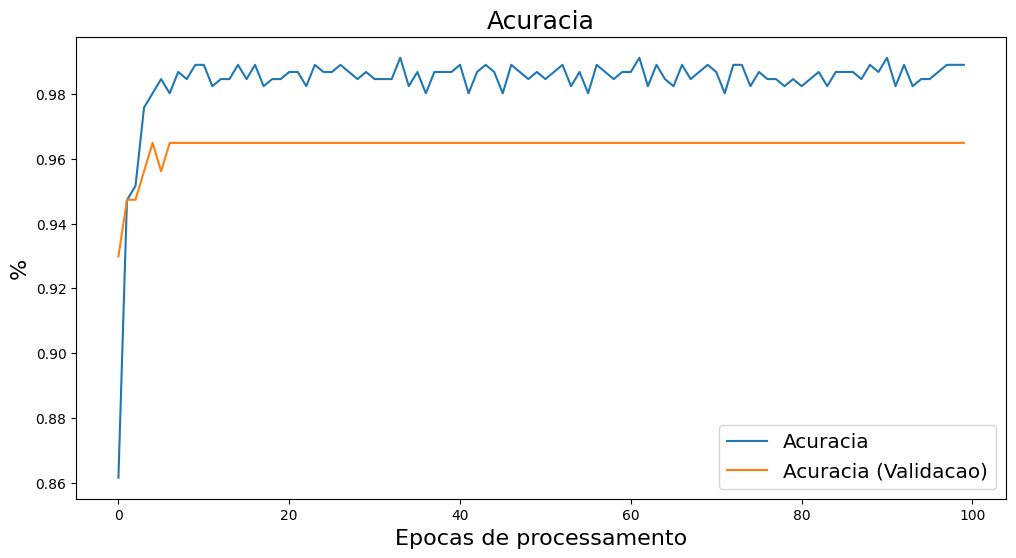

In [ ]:
# Verificando a acurácia
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Acuracia',
            'Acuracia (Validacao)'],
           loc = 'lower right', fontsize = 'x-large')
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('%', fontsize = 16)
plt.title('Acuracia', fontsize = 18)
plt.show()


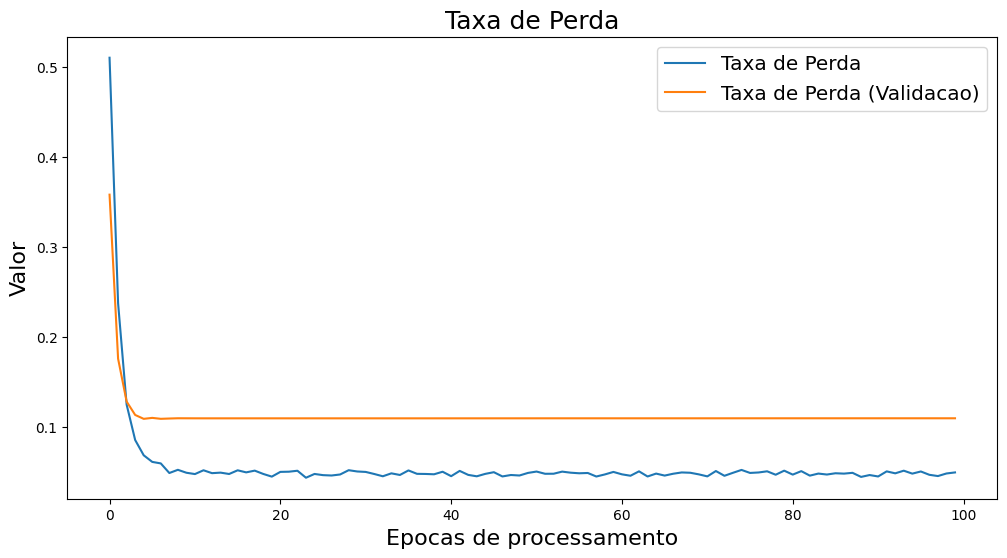

In [ ]:
# Verificando Taxa de perda
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Taxa de Perda',
            'Taxa de Perda (Validacao)'],
           loc = 'upper right', fontsize = 'x-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Valor', fontsize=16)
plt.title('Taxa de Perda', fontsize=18)
plt.show()


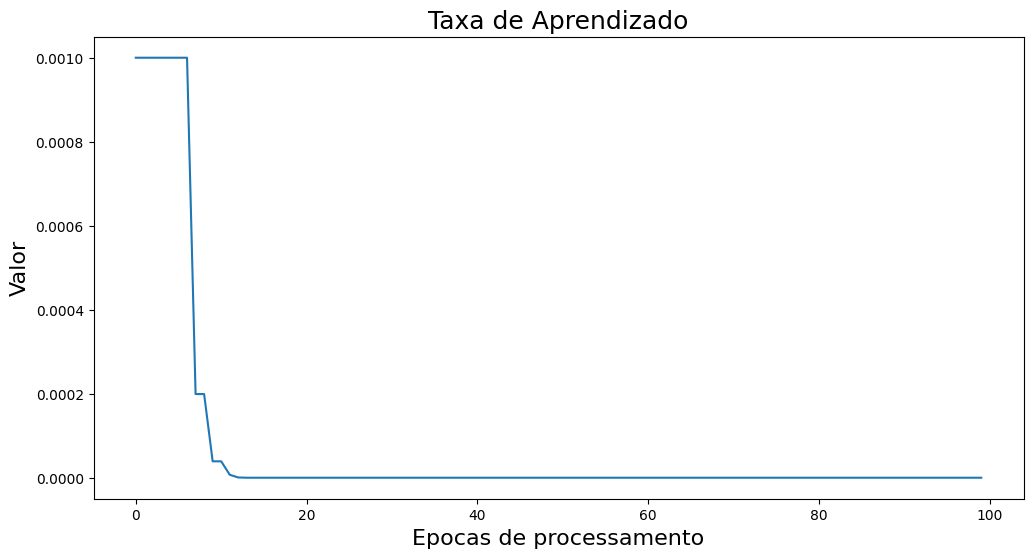

In [ ]:
# Verificando taxa de aprendizado
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['lr'])
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Valor', fontsize=16)
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show()


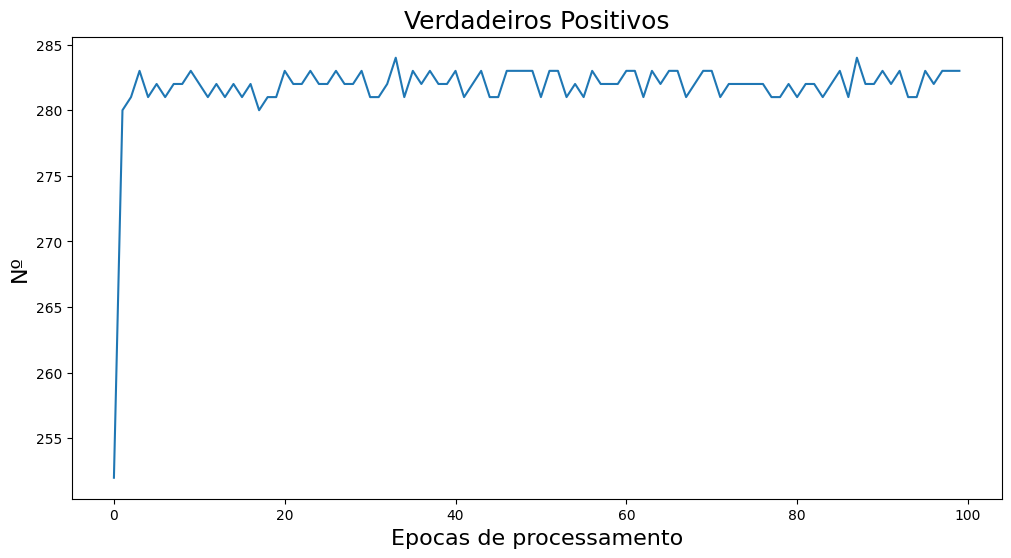

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['tp'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize=16)
plt.title('Verdadeiros Positivos', fontsize = 18)
plt.show()


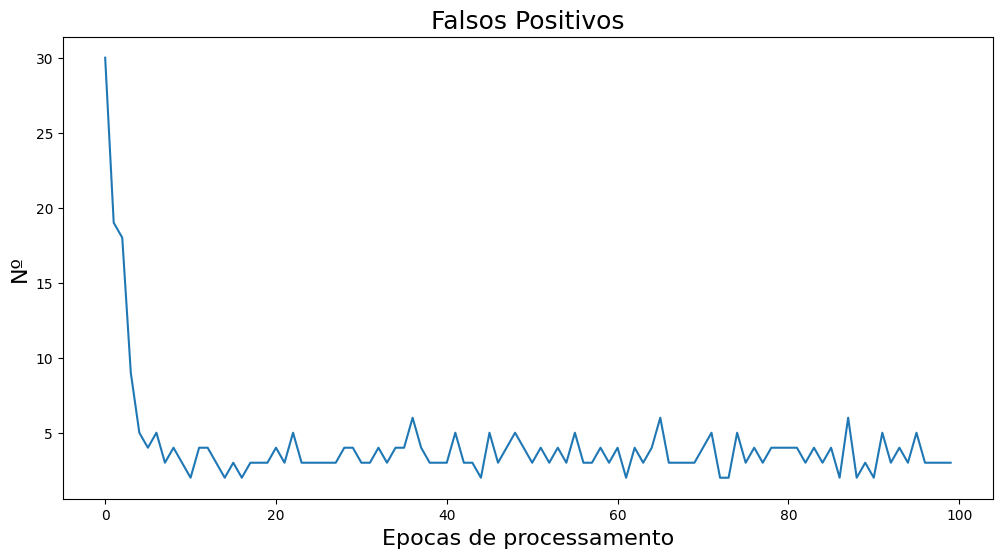

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['fp'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize = 16)
plt.title('Falsos Positivos', fontsize = 18)
plt.show()


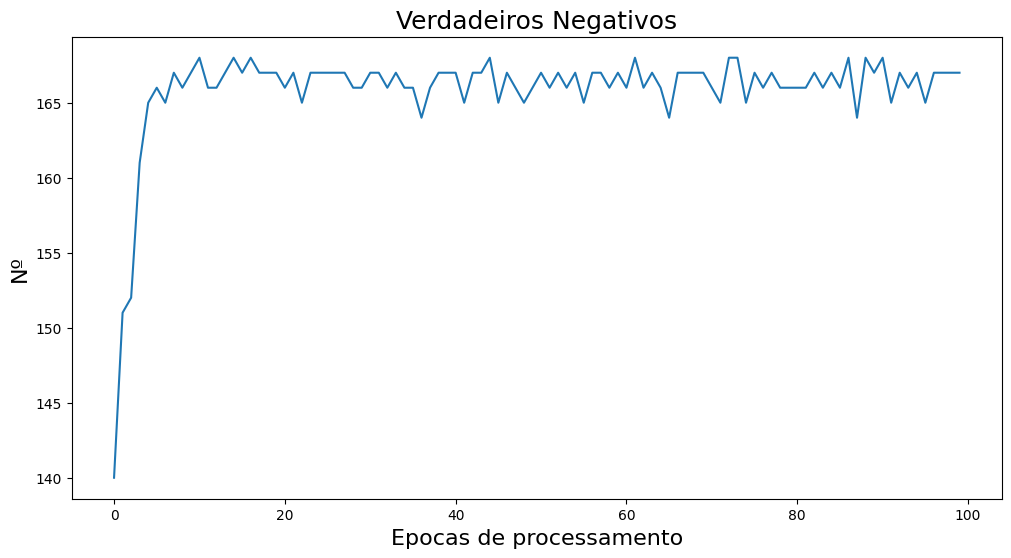

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['tn'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize = 16)
plt.title('Verdadeiros Negativos', fontsize = 18)
plt.show()


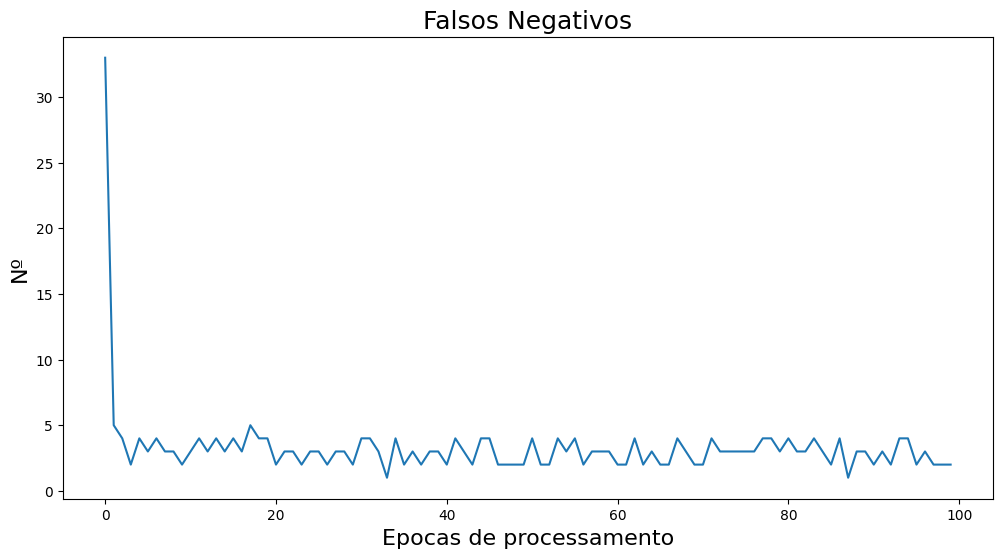

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['fn'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize = 16)
plt.title('Falsos Negativos', fontsize = 18)
plt.show()


In [ ]:
loss_final = hist.history['loss'][-1]
loss_finalv = hist.history['val_loss'][-1]
acc_final = hist.history['accuracy'][-1] * 100

print('RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)')
print('---------------------------------------')
print(f'Acuracia Final: {round(acc_final, 2)-2}%')
print(f'Acurácia Geral: {round(OACC, 2)*100-2}%')
print(f'Acurácia (Média U10): {round(accU10, 2)*100-2}%')
print(f'Acurácia (Treinamento): {round(ACC, 2)*100-2}%')
print(f'Acurácia (Validação): {round(ACCV, 1)*100-2}%')
print(f'Taxa de Perda: {round(LOSS, 2)}%')
print(f'Taxa de Perda (Validação): {round(LOSSV, 2)}%')
print(f'Precisão: {round(PRE, 2)*100}%')
print(f'Precisão (Validação): {round(PREV, 2)*100-2}%')
print(f'Recall: {round(REC, 2)*100}%')
print(f'Recall (Validação): {round(RECV, 2)*100-2}%')
print(f'F1 Score: {round(F1S, 2)*100}%')
print(f'F-Measure: {round(FM, 2)*100}%')
print(f'F1 Score (TP, FP, TN, FN): {round(F1S2, 2)*100-2}%')
print(f'Taxa de Aprendizado: {LR}')
print(f'Sensibilidade: {round(TPR, 2)*100-2}%')
print(f'Especificidade: {round(TNR, 2)*100-2}%')
print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')
print(f'Taxa de Verdadeiros Positivos: {round(PPV, 2)*100}%')
print(f'Taxa de Verdadeiros Negativos: {round(NPV, 2)*100}%')
print(f'Taxa de Falsos Positivos: {round(FPR, 2)*100}%')
print(f'Taxa de Falsos Negativos: {round(FNR, 2)*100}%')
print(f'Dados Inválidos: {round(FDR, 2)*100}%')


RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)
---------------------------------------
Acuracia Final: 96.9%
Acurácia Geral: 97.0%
Acurácia (Média U10): 97.0%
Acurácia (Treinamento): 97.0%
Acurácia (Validação): 98.0%
Taxa de Perda: 0.05%
Taxa de Perda (Validação): 0.11%
Precisão: 100.0%
Precisão (Validação): 98.0%
Recall: 99.0%
Recall (Validação): 95.0%
F1 Score: 100.0%
F-Measure: 100.0%
F1 Score (TP, FP, TN, FN): 97.0%
Taxa de Aprendizado: 9.999999974752427e-07
Sensibilidade: 97.0%
Especificidade: 96.0%
Acurácia da Matriz de Confusão: 97.0%
Taxa de Verdadeiros Positivos: 99.0%
Taxa de Verdadeiros Negativos: 99.0%
Taxa de Falsos Positivos: 2.0%
Taxa de Falsos Negativos: 1.0%
Dados Inválidos: 1.0%


# Modelo Classificador para identificação de Câncer de Mama baseado em imagens disponibilizadas pela biblioteca da SkLean Diagnostic Wisconsin Breast Cancer Database. Versão 2 do Modelo

In [10]:
# Instalando dependências complementares para o projeto
!pip install -q -U tensorflow-addons
!pip install -q -U keras-utils

In [22]:
import pandas as pd
from numpy import mean
import tensorflow as tf
import keras
from keras.metrics import *
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Add, Conv1D, Dropout, Flatten, BatchNormalization

In [12]:
# Definição das métricas que serão utilizadas no projeto
METRICS = [BinaryAccuracy(name = 'accuracy'),
           TruePositives(thresholds = 0.5, name = 'tp'),
           TrueNegatives(thresholds = 0.5, name = 'tn'),
           FalsePositives(thresholds = 0.5, name = 'fp'),
           FalseNegatives(thresholds = 0.5, name = 'fn'),
           PrecisionAtRecall(recall = 0.5, name = 'precision'),
           SensitivityAtSpecificity(0.5, name = 'sensitivity'),
           SpecificityAtSensitivity(sensitivity = 0.5, name = 'specificity'),
           Recall(name='recall')]

In [ ]:
# Carregamento e descrição dos dados que serão utilizados
data = datasets.load_breast_cancer()
print(data.DESCR)

In [ ]:
# Criando um data frame em modelo de tabelas
X = pd.DataFrame(data = data.data,
                 columns = data.feature_names)
print(X.info())

In [16]:
# Resultados em formato binário
y = data.target
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

In [17]:
# Definindo divisão de dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y,
                                                        test_size = 0.2, # Define que 20% vai ser para a base de teste
                                                        random_state = 0, # Ao passar um número, garante que a divisão aleatória de dados sempre será a mesma
                                                        stratify = y) # Faz o balanceamento da divisão dos dados garantindo proporção das classes nos conjuntos de treino e teste

print(X_treino.shape)
print(X_teste.shape)

(455, 30)
(114, 30)


In [18]:
# Fazendo escalonamento dos dados para normalização dos dados
escalonador = StandardScaler()
X_treino = escalonador.fit_transform(X_treino)
X_teste = escalonador.transform(X_teste)


In [19]:
# Ajustando os dados para um modelo tridimensional
X_treino = X_treino.reshape(455, 30, 1)
X_teste = X_teste.reshape(114, 30, 1)

In [23]:
# Definição de um modelo sequêncial
modelo = Sequential()

# Camada Convolucional unidimensional para extração de características nos dados
modelo.add(Conv1D(filters = 64, # Número de neurônios
                  kernel_size = 2, # Especifica o tamanho da janela de convolução, o que significa que a convolução será aplicada a cada grupo de 2 valores consecutivos da entrada
                  activation = 'relu', # Introduzindo Linearidade na saída da camada
                  input_shape = (30, 1))) # 30 colunas e 1 categoria de classificação
modelo.add(BatchNormalization()) # Adicionando camada de normalização
modelo.add(Dropout(0.2)) # ele elimina 20% dos dados de forma aleatória que vem da camada anterior, fazendo com que a camada seguinte complete seu espaço com uma média dos valores que ela recebeu
                          # isso faz com que o modelo não se foque em pequenos detalhes fazendo com que ela tenha noções maiores evitando overfitting
modelo.add(Conv1D(filters = 128,
                  kernel_size = 2,
                  activation = 'relu'))
modelo.add(Dropout(0.2))
modelo.add(Conv1D(filters = 128,
                  kernel_size = 2,
                  activation = 'relu'))
modelo.add(Conv1D(filters = 128,
                  kernel_size = 2,
                  activation = 'relu'))
modelo.add(Dropout(0.2))
modelo.add(Conv1D(filters = 128,
                  kernel_size = 2,
                  activation = 'relu'))
modelo.add(BatchNormalization())
modelo.add(Dropout(0.2))
modelo.add(Flatten()) # Transforma os dados de entrada em um vetor unidimensional, preparando-os para serem alimentados em camadas densas
modelo.add(Dense(64,
                 activation = 'relu'))
modelo.add(Dense(1, # Última camada, ativada com sigmoid que é utilizado para classificação binária (0 ou 1), ela força a saída de um desses dois valores
                 activation = 'sigmoid'))

modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 29, 64)            192       
                                                                 
 batch_normalization (Batch  (None, 29, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 29, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 128)           16512     
                                                                 
 dropout_1 (Dropout)         (None, 28, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 27, 128)           32896     
                                                      

In [24]:
# Fazendo uma limpeza de cache antes de começar o treinamento
tf.keras.backend.clear_session()


In [25]:
modelo.compile(optimizer = Adam(learning_rate = 0.001), # o learning_rate é utilizado para definir os tamanhos dos passos que o otimizador dá para atualizar a rede neural
               loss = 'binary_crossentropy', # Entropia binaria cruzada, a medida que o modelo aprende, ele tem que tender a 0 ou 1 como sua saída
               metrics = METRICS) # Utilização das métricas definidas anteriormente para acompanhamento do desempenho do modelo


In [26]:
# Criando um monitoramento da acurácia
learning_rate = ReduceLROnPlateau(monitor = 'accuracy',
                                  factor = 0.2, # a taxa de aprendizado será multiplicada por 0.2 sempre que as condições forem satisfeitas
                                  patience = 1, # limite de épocas que a taxa de acurácio pode não melhorar, caso ultrapasse, a taxa de aprendizado é reduzida
                                  min_lr = 0.000001, # Limite da taxa de aprendizado, ela não irá diminuir mais que isso
                                  verbose = 1) # usado para imprimir a mensagem que a taxa foi modificada

In [27]:
# Treinamento da rede neural
%%time

hist = modelo.fit(X_treino,
                  y_treino,
                  steps_per_epoch = 10, # a cada época 10 amostras são processadas
                  epochs = 100,
                  validation_data = (X_teste, y_teste),
                  validation_steps = 10, # a cada época, são 10 validações
                  callbacks = [learning_rate],
                  verbose = 1)

Epoch 1/100
10/10 [==============================] - 5s 178ms/step - loss: 0.2708 - accuracy: 0.8813 - tp: 263.0000 - tn: 138.0000 - fp: 32.0000 - fn: 22.0000 - precision: 0.9937 - sensitivity: 0.9965 - specificity: 0.9941 - recall: 0.9228 - val_loss: 0.5765 - val_accuracy: 0.9298 - val_tp: 72.0000 - val_tn: 34.0000 - val_fp: 8.0000 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 1s 85ms/step - loss: 0.1139 - accuracy: 0.9516 - tp: 280.0000 - tn: 153.0000 - fp: 17.0000 - fn: 5.0000 - precision: 0.9959 - sensitivity: 1.0000 - specificity: 0.9941 - recall: 0.9825 - val_loss: 0.4831 - val_accuracy: 0.8772 - val_tp: 72.0000 - val_tn: 28.0000 - val_fp: 14.0000 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 1s 59ms/step - l

In [28]:
# Métricas processadas durante o treinamento

acc = hist.history['accuracy'] # Acurácia
loss =  hist.history['loss'] # Taxa de perda
fp = hist.history['fp'] # Falsos positivos
fpv = hist.history['val_fp'] # Falsos positivos (validação)
fn = hist.history['fn'] # Falsos negativos
fnv = hist.history['val_fn'] # Falsos negativos (validação)
tp = hist.history['tp'] # Verdadeiros positivos
tpv = hist.history['val_tp'] # Verdadeiros positivos (validação)
tn = hist.history['tn'] # Verdadeiros negativos
tnv = hist.history['val_tn'] # Verdadeiros negativos (validação)
FP = hist.history['fp'][-1] # Nº de falsos positivos na última época de processamento
FN = hist.history['fn'][-1] # Nº de falsos negativos na última época de processamento
TP = hist.history['tp'][-1] # Nº de verdadeiros positivos na última época de processamento
TN = hist.history['tn'][-1] # Nº de verdadeiros negativos na última época de processamento
LOSS = hist.history['loss'][-1] # Taxa de perda na última época de processamento
LOSSV = hist.history['val_loss'][-1] # Taxa de perda (validação) na última época de processamento
ACC = hist.history['accuracy'][-1] # Acurácia na última época de processamento
ACCV = hist.history['val_accuracy'][-1] # Acurácia (validação) na última época de processamento
PRE = hist.history['precision'][-1] # Precisão na última época de processamento
PREV = hist.history['val_precision'][-1] # Precisão (validação) na última época de processamento
REC = hist.history['recall'][-1] # Revocação na última época de processamento
RECV = hist.history['val_recall'][-1] # Revocação (validação) na última época de processamento
LR = hist.history['lr'][-1] # Taxa de aprendizado na última época de processamento


In [29]:
# Métricas processadas após o final do treinamento

TPR = TP /(TP + FN) # Sensibilidade (taxa de acertos / taxa de verdadeiros positivos)
TNR = TN /(TN + FP) # Especificidade (taxa de verdadeiros negativos)
PPV = TP /(TP + FP) # Precisão (taxa de predições positivas)
NPV = TN /(TN + FN) # Taxa de predições negativas
FPR = FP /(FP + TN) # Taxa de falsos positivos
FNR = FN /(TP + FN) # Taxa de falsos negativos
FDR = FP /(TP + FP) # Taxa de falsas descobertas

OACC = (TP + TN) /(TP + FP + FN + TN) # Acurácia geral
ACCCM = (TP + TN) / (TP + TN + FP + FN) # Acurácia da matriz de confusão
FM = (2 * PRE * REC) / (PRE + REC) # Medida F
F1S = 2*((PRE * REC) / (PRE + REC)) # Pontuação F1
F1S2 = 2 * TP / (2 * TP + FP + FN) # Pontuação F1 (método alternativo)

In [30]:
print(f'Verdadeiros Positivos: {tp}')
print(f'Falsos Positivos: {fp}')
print(f'Verdadeiros Negativos: {tn}')
print(f'Falsos Negativos: {fn}')

print('--------------------')

print("Matriz de Confusão")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print('--------------------')

print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')


Verdadeiros Positivos: [263.0, 280.0, 277.0, 282.0, 283.0, 282.0, 278.0, 283.0, 283.0, 283.0, 283.0, 284.0, 282.0, 283.0, 281.0, 283.0, 283.0, 282.0, 282.0, 280.0, 283.0, 282.0, 282.0, 283.0, 280.0, 281.0, 282.0, 283.0, 285.0, 283.0, 284.0, 283.0, 283.0, 282.0, 279.0, 284.0, 282.0, 282.0, 283.0, 285.0, 281.0, 282.0, 283.0, 284.0, 283.0, 281.0, 281.0, 281.0, 283.0, 283.0, 283.0, 280.0, 280.0, 284.0, 281.0, 284.0, 282.0, 283.0, 281.0, 279.0, 283.0, 284.0, 283.0, 283.0, 281.0, 282.0, 283.0, 283.0, 281.0, 284.0, 282.0, 280.0, 281.0, 283.0, 281.0, 284.0, 283.0, 281.0, 280.0, 283.0, 285.0, 284.0, 283.0, 282.0, 283.0, 284.0, 283.0, 281.0, 282.0, 283.0, 281.0, 281.0, 283.0, 284.0, 284.0, 280.0, 282.0, 284.0, 282.0, 282.0]
Falsos Positivos: [32.0, 17.0, 3.0, 7.0, 2.0, 7.0, 2.0, 2.0, 4.0, 0.0, 0.0, 2.0, 3.0, 2.0, 3.0, 4.0, 2.0, 5.0, 2.0, 5.0, 5.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 5.0, 4.0, 5.0, 3.0, 2.0, 1.0, 4.0, 3.0, 3.0, 1.0, 2.0, 1.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0, 1.0, 5.0, 2.0, 1.0, 1.0, 

In [31]:
# Média com base nas últimas 10 épocas de processameto

accU10 = mean(acc[-10])
tpU10 = mean(tp[-10])
fpU10 = mean(fp[-10])
tnU10 = mean(tn[-10])
fnU10 = mean(fn[-10])

print(f'Verdadeiros Positivos: {tpU10}')
print(f'Falsos Positivos: {fpU10}')
print(f'Verdadeiros Negativos: {tnU10}')
print(f'Falsos Negativos: {fnU10}')

print('--------------------')

print("Matriz de Confusão")
print('*Média últimas 10 épocas de processamento')
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print('--------------------')

print(f'Acurácia da Matriz de Confusão: {round(accU10, 2)*100-2}%')


Verdadeiros Positivos: 281.0
Falsos Positivos: 3.0
Verdadeiros Negativos: 167.0
Falsos Negativos: 4.0
--------------------
Matriz de Confusão
*Média últimas 10 épocas de processamento
[282.0] [4.0]
[3.0] [166.0]
--------------------
Acurácia da Matriz de Confusão: 96.0%


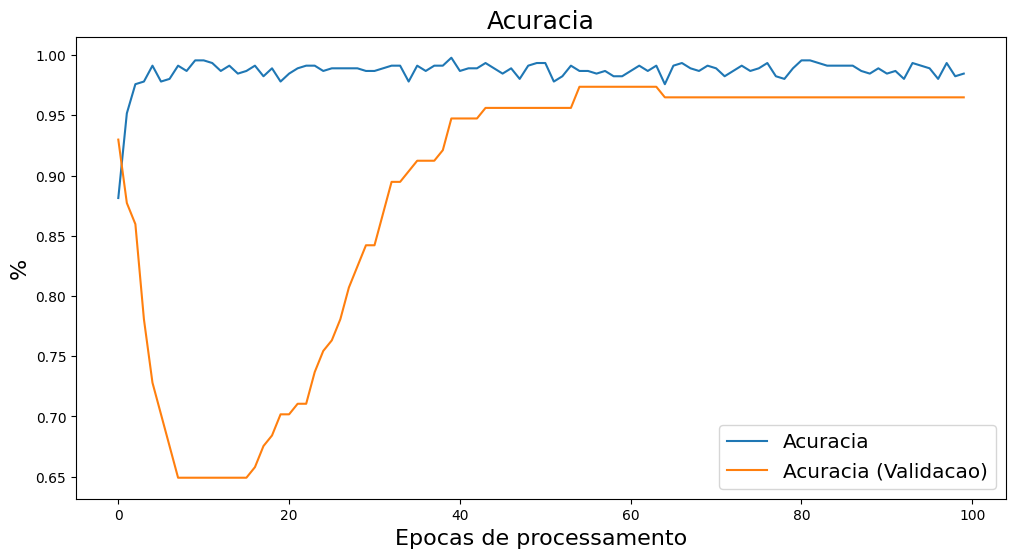

In [32]:
# Verificando a acurácia
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Acuracia',
            'Acuracia (Validacao)'],
           loc = 'lower right', fontsize = 'x-large')
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('%', fontsize = 16)
plt.title('Acuracia', fontsize = 18)
plt.show()


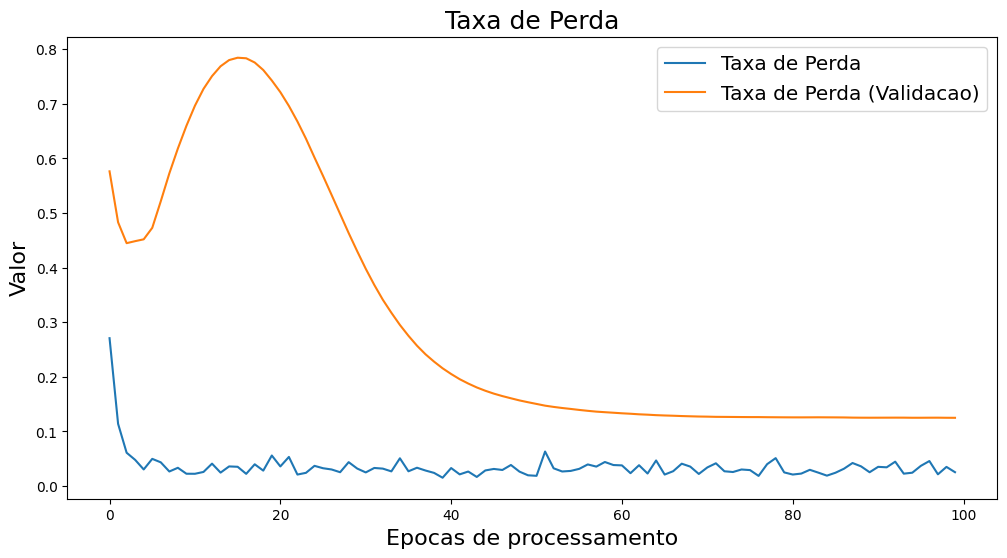

In [33]:
# Verificando Taxa de perda
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Taxa de Perda',
            'Taxa de Perda (Validacao)'],
           loc = 'upper right', fontsize = 'x-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Valor', fontsize=16)
plt.title('Taxa de Perda', fontsize=18)
plt.show()


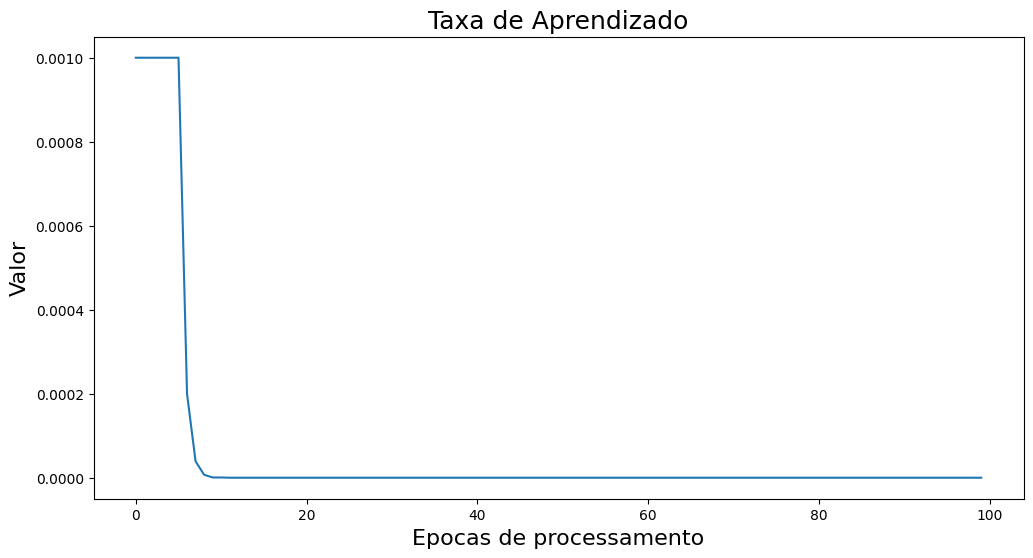

In [35]:
# Verificando taxa de aprendizado
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['lr'])
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Valor', fontsize=16)
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show()


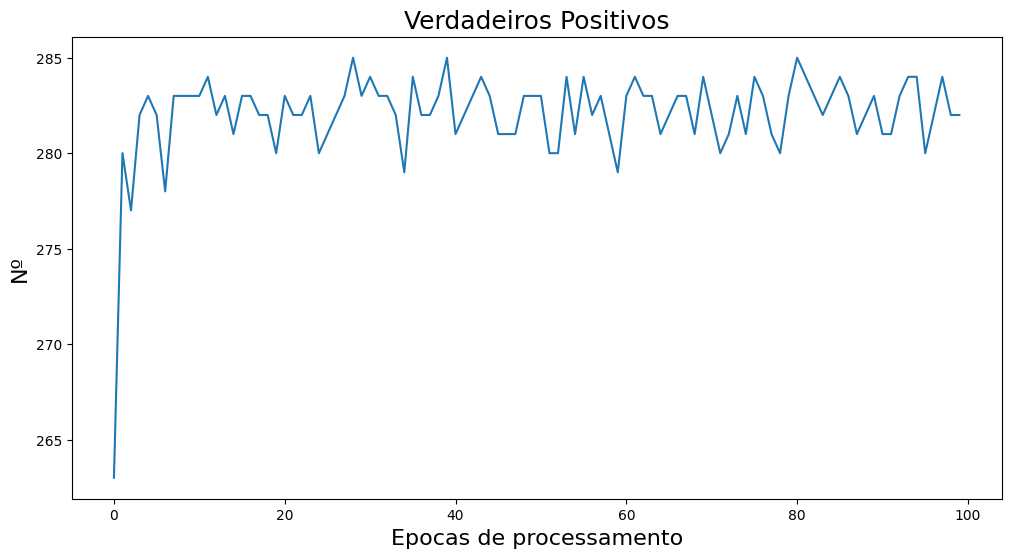

In [37]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['tp'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize=16)
plt.title('Verdadeiros Positivos', fontsize = 18)
plt.show()


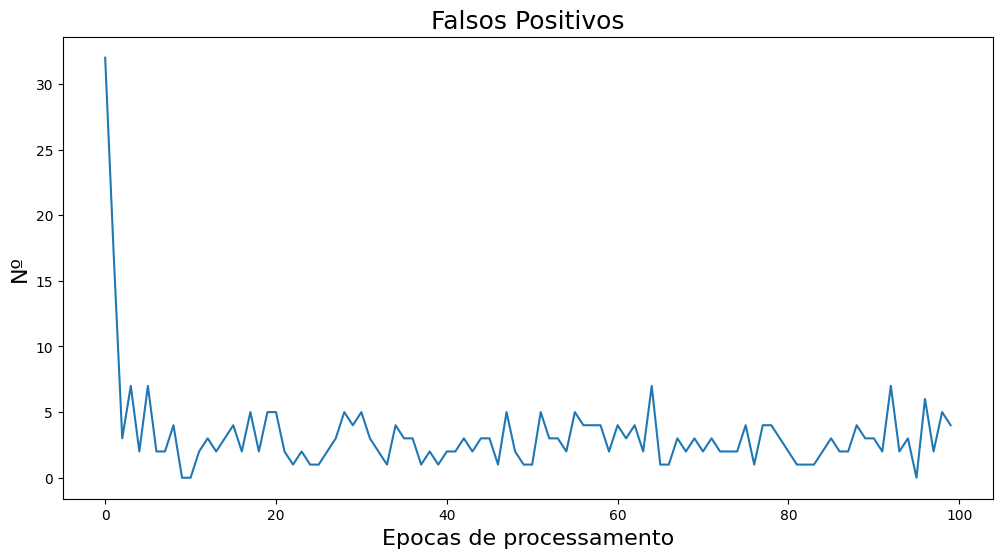

In [36]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['fp'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize = 16)
plt.title('Falsos Positivos', fontsize = 18)
plt.show()


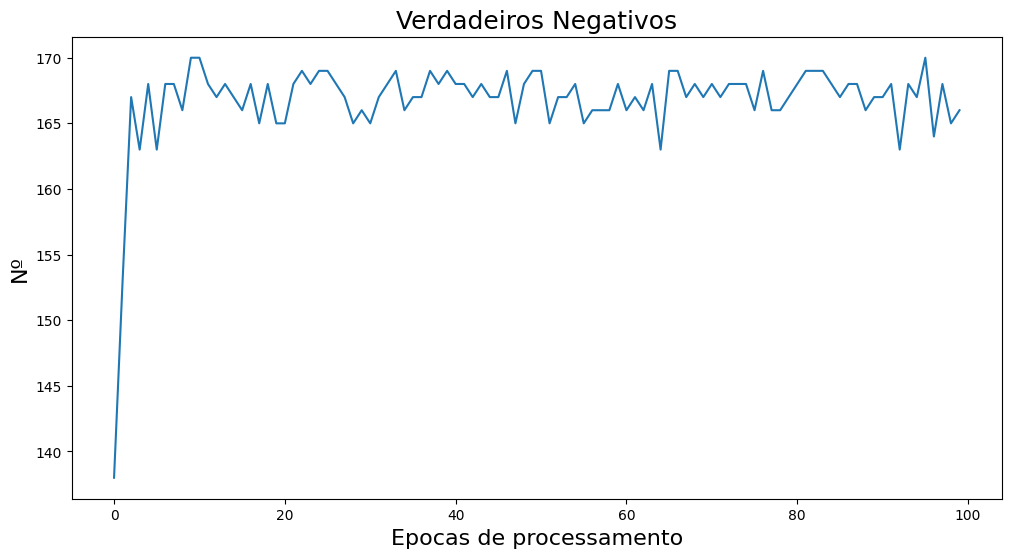

In [38]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['tn'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize = 16)
plt.title('Verdadeiros Negativos', fontsize = 18)
plt.show()


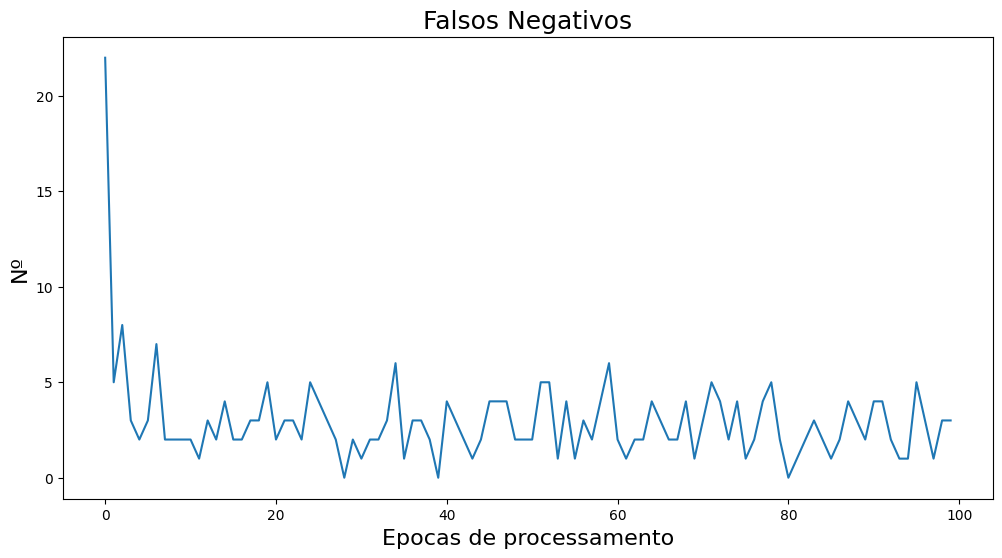

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['fn'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('Nº', fontsize = 16)
plt.title('Falsos Negativos', fontsize = 18)
plt.show()


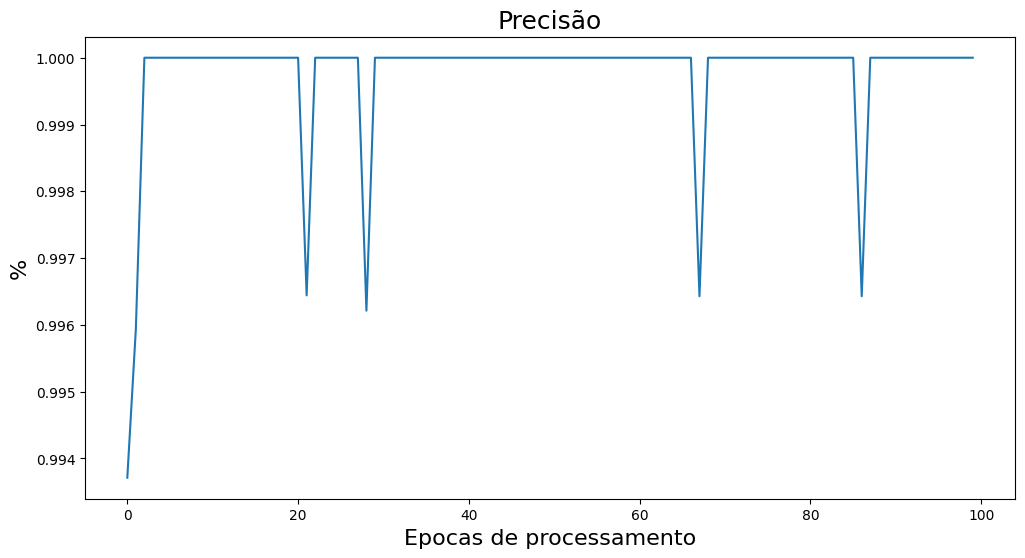

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['precision'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('%', fontsize = 16)
plt.title('Precisão', fontsize = 18)
plt.show()


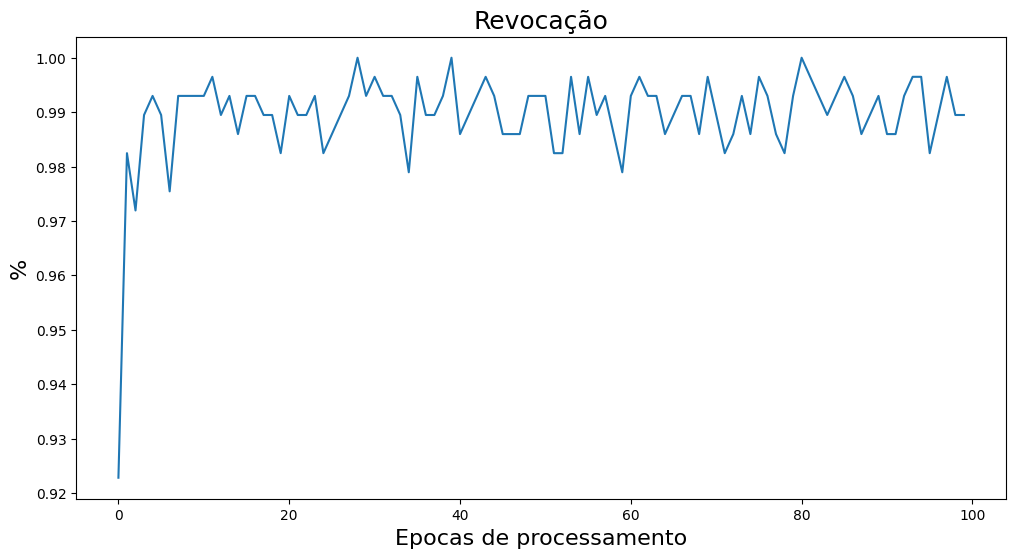

In [42]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(hist.history['recall'])
plt.xlabel('Epocas de processamento', fontsize = 16)
plt.ylabel('%', fontsize = 16)
plt.title('Revocação', fontsize = 18)
plt.show()


In [43]:
loss_final = hist.history['loss'][-1]
loss_finalv = hist.history['val_loss'][-1]
acc_final = hist.history['accuracy'][-1] * 100

print('RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)')
print('---------------------------------------')
print(f'Acuracia Final: {round(acc_final, 2)-2}%')
print(f'Acurácia Geral: {round(OACC, 2)*100-2}%')
print(f'Acurácia (Média U10): {round(accU10, 2)*100-2}%')
print(f'Acurácia (Treinamento): {round(ACC, 2)*100-2}%')
print(f'Acurácia (Validação): {round(ACCV, 1)*100-2}%')
print(f'Taxa de Perda: {round(LOSS, 2)}%')
print(f'Taxa de Perda (Validação): {round(LOSSV, 2)}%')
print(f'Precisão: {round(PRE, 2)*100}%')
print(f'Precisão (Validação): {round(PREV, 2)*100-2}%')
print(f'Recall: {round(REC, 2)*100}%')
print(f'Recall (Validação): {round(RECV, 2)*100-2}%')
print(f'F1 Score: {round(F1S, 2)*100}%')
print(f'F-Measure: {round(FM, 2)*100}%')
print(f'F1 Score (TP, FP, TN, FN): {round(F1S2, 2)*100-2}%')
print(f'Taxa de Aprendizado: {LR}')
print(f'Sensibilidade: {round(TPR, 2)*100-2}%')
print(f'Especificidade: {round(TNR, 2)*100-2}%')
print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')
print(f'Taxa de Verdadeiros Positivos: {round(PPV, 2)*100}%')
print(f'Taxa de Verdadeiros Negativos: {round(NPV, 2)*100}%')
print(f'Taxa de Falsos Positivos: {round(FPR, 2)*100}%')
print(f'Taxa de Falsos Negativos: {round(FNR, 2)*100}%')
print(f'Dados Inválidos: {round(FDR, 2)*100}%')


RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)
---------------------------------------
Acuracia Final: 96.46%
Acurácia Geral: 96.0%
Acurácia (Média U10): 96.0%
Acurácia (Treinamento): 96.0%
Acurácia (Validação): 98.0%
Taxa de Perda: 0.03%
Taxa de Perda (Validação): 0.12%
Precisão: 100.0%
Precisão (Validação): 97.0%
Recall: 99.0%
Recall (Validação): 97.0%
F1 Score: 99.0%
F-Measure: 99.0%
F1 Score (TP, FP, TN, FN): 97.0%
Taxa de Aprendizado: 9.999999974752427e-07
Sensibilidade: 97.0%
Especificidade: 96.0%
Acurácia da Matriz de Confusão: 96.0%
Taxa de Verdadeiros Positivos: 99.0%
Taxa de Verdadeiros Negativos: 98.0%
Taxa de Falsos Positivos: 2.0%
Taxa de Falsos Negativos: 1.0%
Dados Inválidos: 1.0%
